<a href="https://colab.research.google.com/github/HenryLau08/adsai-mlops-2025/blob/main/MLOPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLOPs Portfolio


|Naam|studentnummer|Github|
|----|-------------|------|
|Henry Lau|22122958|HenryLau08|
|Mohamed Belaachir|22143572|Mobelaachir|
||||
||||

In [2]:
# %pip install kaggle
# %pip install ultralytics
# %pip install mlflow
# %pip install opencv-python

In [14]:
# Standaardbibliotheken
import os
import shutil
import zipfile
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor

# Dataverwerking
import pandas as pd
import numpy as np
import yaml

# Visualisatie
import matplotlib.pyplot as plt
import seaborn as sns

# Afbeeldingen & Preprocessing
import cv2
from PIL import Image
import hashlib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Deep Learning (TensorFlow / Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
    Dense, Flatten, Dropout, BatchNormalization
)

# ========== Externe Tools & Tracking ==========
# from ultralytics import YOLO
from google.colab import drive
# import mlflow

# Configuratie
# run it once
# os.makedirs("/root/.config/kaggle/", exist_ok=True)
# shutil.move("kaggle.json", "/root/.config/kaggle/") # manually upload your kaggle.json file and run it once
# !chmod 600 /root/.config/kaggle/kaggle.json
# import kaggle

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


Deze code maakt de juiste mappen aan die nodig zijn voor het project. Er wordt een map in Google Drive klaargezet om data op te slaan of te gebruiken. Ook wordt een speciale map gemaakt voor de instellingen van de Kaggle API, zodat data van Kaggle automatisch kan worden gedownload. Als de mappen al bestaan, geeft de code geen foutmelding.

In [5]:
base_dir = Path("/content/drive/MyDrive/Colab Notebooks/data")
base_dir.mkdir(parents=True, exist_ok=True)

# 1. INLEIDING

In dit project willen we een voertuigherkenningssysteem ontwikkelen dat werkt op edge-apparaten. Het systeem moet voertuigen herkennen en classificeren op basis van afbeeldingen, bijvoorbeeld als auto, bus, vrachtwagen of ander type voertuig. Het systeem bestaat uit twee onderdelen:

- **Edge Model:** Dit is een snel en lichtgewicht objectdetectiemodel dat voertuigen kan herkennen en uitsnijden uit de -aangeleverde afbeeldingen. Het model is geoptimaliseerd voor edge-apparaten, zodat het efficiënt functioneert op systemen met beperkte rekenkracht.

- **Cloud Model:** Dit is een geavanceerd deep learning-model dat het type voertuig bepaalt aan de hand van de uitsnedes die door het edge-apparaat zijn doorgestuurd.


# 2. Data Ingestion

Voor dit project is gebruikgemaakt van data afkomstig van Kaggle. De dataset bevat afbeeldingen van verschillende soorten voertuigen, zoals auto’s, bussen, vrachtwagens en motorfietsen. Deze data is gedownload met behulp van de Kaggle API en vervolgens opgeslagen in een gestructureerde mapindeling op Google Drive, zodat de afbeeldingen eenvoudig konden worden ingeladen voor verdere verwerking. Er zijn twee datasets gebruikt: één voor het edge-model en één voor het cloud-model.

- **Edge Model:** Het kleinere edge-model detecteert alleen voertuigen, zodat het snel en efficiënt kan draaien op edge-apparaten.

- **Cloud Model:** Het grotere model is verantwoordelijk voor het detecteren van voertuigen en het annoteren van de bijbehorende labels.



## 2.1 Kaggle Datasets

Er wordt een speciale map aangemaakt om de Kaggle-datasets op te slaan. Vervolgens wordt een voertuigdetectiedataset automatisch gedownload en uitgepakt in deze map, zodat de data direct klaarstaat voor gebruik in het project.

https://www.kaggle.com/datasets/sakshamjn/vehicle-detection-8-classes-object-detection

In [17]:
kaggle_path = base_dir / 'kaggle'

# # if kaggle directory exists, delete and redownload data
# if kaggle_path.exists():
#     shutil.rmtree(kaggle_path)

# os.makedirs(kaggle_path, exist_ok=True)

# kaggle.api.dataset_download_files("sakshamjn/vehicle-detection-8-classes-object-detection", path=kaggle_path, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/sakshamjn/vehicle-detection-8-classes-object-detection


De code telt het aantal bestanden in de map met trainingsafbeeldingen binnen de Kaggle-dataset. Hiermee wordt bepaald hoeveel trainingsafbeeldingen beschikbaar zijn voor het model.

In [18]:
print(len(os.listdir(os.path.join(kaggle_path, 'train/images'))))

8219


De trainset bevat 8.219 afbeeldingen van voertuigen die gebruikt worden voor het trainen van het model.

Er wordt een lijst gemaakt van alle afbeeldingen in de trainingsmap, waarbij alleen bestanden met '.jpg' worden meegenomen. Daarna wordt voor elke afbeelding de naam van het bijbehorende labelbestand gemaakt door de bestandsnaam te veranderen naar '.txt'. Zo horen de labels bij de juiste afbeeldingen.

In [19]:
images_path = kaggle_path / "train/images"
labels_path = kaggle_path / "train/labels"

Met de functies hieronder zien we dat de images allemaal JPEG format zijn en de labels '.txt'.

In [ ]:
def check_image_formats(directory):
  """
  Image formats worden gecheckt en de aantallen ervan.

  Parameters:
  -----------
  directory: path naar de image directory.

  Returns:
  --------
  formats: een dictionary met de aantallen van elke image format.
  """
  formats = {}
  for filename in os.listdir(directory):
      filepath = os.path.join(directory, filename)
      if os.path.isfile(filepath):
          try:
              with Image.open(filepath) as img:
                  fmt = img.format
                  formats[fmt] = formats.get(fmt, 0) + 1
          except Exception:
              pass  # Skip non-images or unreadable files
  return formats

formats_found = check_image_formats(images_path)
print(formats_found)

{'JPEG': 8218}


In [ ]:
def check_text_formats(directory):
  """
  Checkt of alle bestanden in de directory een .txt extensie hebben.

  Parameters:
  -----------
  directory: path naar de label directory.

  Returns:
  --------
  if all_txt:
      print("✅ All files are .txt files.")
  else:
      print("❌ Found non-.txt files:")
      for file in non_txt_files:
          print(" -", file)

  """
  all_txt = True
  non_txt_files = []

  for filename in os.listdir(directory):
      filepath = os.path.join(directory, filename)
      if os.path.isfile(filepath):
          if not filename.lower().endswith('.txt'):
              all_txt = False
              non_txt_files.append(filename)

  if all_txt:
      print("✅ All files are .txt files.")
  else:
      print("❌ Found non-.txt files:")
      for file in non_txt_files:
          print(" -", file)


check_text_formats(labels_path)

✅ All files are .txt files.


We checken of er duplicaten zitten in de image directory, als er zijn halen we ze eruit en de bijbehorende labels ervan.

In [20]:
hashes = {}
duplicates = []

# Doorloop alle afbeeldingsbestanden
for name in os.listdir(images_path):
    image_path = os.path.join(images_path, name)
    if not os.path.isfile(image_path):
        continue

    with open(image_path, 'rb') as f:
        hash_ = hashlib.md5(f.read()).hexdigest()
        if hash_ in hashes:
            duplicates.append(image_path)
        else:
            hashes[hash_] = image_path

# Verwijder duplicaten en bijbehorende labels
print(f"🧹 Verwijderen van {len(duplicates)} dubbele afbeeldingen...")

for image_path in duplicates:
    try:
        os.remove(image_path)
        print(f"🗑️ Verwijderd: {image_path}")

        # Zoek en verwijder bijbehorend labelbestand
        base = os.path.splitext(os.path.basename(image_path))[0]
        label_file = os.path.join(labels_path, f"{base}.txt")
        if os.path.exists(label_file):
            os.remove(label_file)
            print(f"🗑️ Bijbehorend label verwijderd: {label_file}")

    except Exception as e:
        print(f"⚠️ Fout bij verwijderen van {image_path}: {e}")

🧹 Verwijderen van 9 dubbele afbeeldingen...
🗑️ Verwijderd: /content/drive/MyDrive/Colab Notebooks/data/kaggle/train/images/highway_2529_2020-08-26.jpg
🗑️ Bijbehorend label verwijderd: /content/drive/MyDrive/Colab Notebooks/data/kaggle/train/labels/highway_2529_2020-08-26.txt
🗑️ Verwijderd: /content/drive/MyDrive/Colab Notebooks/data/kaggle/train/images/highway_2580_2020-08-26.jpg
🗑️ Bijbehorend label verwijderd: /content/drive/MyDrive/Colab Notebooks/data/kaggle/train/labels/highway_2580_2020-08-26.txt
🗑️ Verwijderd: /content/drive/MyDrive/Colab Notebooks/data/kaggle/train/images/highway_2749_2020-08-26.jpg
🗑️ Bijbehorend label verwijderd: /content/drive/MyDrive/Colab Notebooks/data/kaggle/train/labels/highway_2749_2020-08-26.txt
🗑️ Verwijderd: /content/drive/MyDrive/Colab Notebooks/data/kaggle/train/images/highway_2755_2020-08-26.jpg
🗑️ Bijbehorend label verwijderd: /content/drive/MyDrive/Colab Notebooks/data/kaggle/train/labels/highway_2755_2020-08-26.txt
🗑️ Verwijderd: /content/driv

In [21]:
def extract_labels_and_bboxes(label_file):
    """
    Leest een labelbestand en geeft per regel een label en bbox-coördinaten terug als tuple.
    Args:
        label_file (str): Pad naar het labelbestand.
    Yields:
        tuple: Een tuple van (label, bbox) waar label een integer is en bbox een lijst van vier floats.
    """
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split(' ')
            yield int(parts[0]), [float(x) for x in parts[1:]]

In [22]:
def load_kaggle_dataset(images_path, labels_path):
    """
    Laadt de Kaggle dataset en retourneert een DataFrame met image paths, labels en bounding boxes.
    Args:
        images_path (str): Pad naar de map met afbeeldingen.
        labels_path (str): Pad naar de map met labelbestanden.
    Returns:
        pd.DataFrame
    """
    data = []
    images = [f for f in os.listdir(images_path) if f.endswith('.jpg')]
    labels = [f.replace('.jpg', '.txt') for f in images]

    for img, lbl in tqdm(zip(images, labels), total=len(images)):
        label_file = os.path.join(labels_path, lbl)
        for label, bbox in extract_labels_and_bboxes(label_file):
            data.append({
                'image_path': os.path.join(images_path, img),
                'label_path': label_file,
                'label': label,
                'x_center': bbox[0],
                'y_center': bbox[1],
                'width': bbox[2],
                'height': bbox[3]
            })
    return pd.DataFrame(data)

Er wordt eerst gekeken of er al een CSV-bestand met de gegevens bestaat. Als dat bestand er nog niet is, wordt de dataset ingeladen en daarna opgeslagen als CSV. Als het bestand al bestaat, wordt de data direct uit het CSV-bestand geladen. Zo hoeft het inladen van de dataset niet steeds opnieuw te gebeuren.

In [23]:
csv_path = os.path.join(base_dir, 'kaggle_data.csv')
if not os.path.exists(csv_path):
    df_kaggle = load_kaggle_dataset(images_path, labels_path)
    df_kaggle.to_csv(csv_path, index=False)
else:
    df_kaggle = pd.read_csv(csv_path)

100%|██████████| 8209/8209 [00:20<00:00, 401.43it/s]


In [24]:
display(df_kaggle.head(5))

,image_path,label_path,label,x_center,y_center,width,height
0,/content/drive/MyDrive/Colab Notebooks/data/ka...,/content/drive/MyDrive/Colab Notebooks/data/ka...,3,0.509804,0.411765,0.107843,0.245098
1,/content/drive/MyDrive/Colab Notebooks/data/ka...,/content/drive/MyDrive/Colab Notebooks/data/ka...,2,0.210784,0.616422,0.127451,0.232843
2,/content/drive/MyDrive/Colab Notebooks/data/ka...,/content/drive/MyDrive/Colab Notebooks/data/ka...,0,0.503750,0.405000,0.097500,0.245000
3,/content/drive/MyDrive/Colab Notebooks/data/ka...,/content/drive/MyDrive/Colab Notebooks/data/ka...,1,0.190000,0.598750,0.120000,0.232500
4,/content/drive/MyDrive/Colab Notebooks/data/ka...,/content/drive/MyDrive/Colab Notebooks/data/ka...,2,0.621250,0.610000,0.057500,0.125000


- De afbeeldingen hebben verschillende afmetingen en zijn dus niet allemaal even groot.

In [25]:
def get_image_size(path):
    """
    Haalt de afmetingen van een afbeelding op.
    Args:
        path (str): Pad naar de afbeelding.
    Returns:
        tuple: Afmetingen van de afbeelding (breedte, hoogte) of None bij een fout.

    """
    try:
        with Image.open(path) as img:
            return img.size
    except Exception as e:
        print(f"Fout bij openen van {path}: {e}")
        return None

with ThreadPoolExecutor(max_workers=8) as executor:
    sizes = list(executor.map(get_image_size, set(df_kaggle['image_path'])))

# Remove None values and get unique sizes
image_sizes = sorted(set(s for s in sizes if s is not None))

print(image_sizes)

[(382, 382), (384, 384), (388, 388), (390, 390), (392, 392), (394, 394), (396, 396), (398, 398), (400, 400), (402, 402), (404, 404), (406, 406), (408, 408), (410, 410), (412, 412), (416, 416), (640, 480), (640, 640)]


Er zijn meerdere versies of copies van hetzelfde foto. We willen unieke foto's hebben om nadien elk label nummer te gaan bekijken tot welk label voertuig ze behoren.

In [41]:
def get_base_name(filename):
    # Extract e.g. "Highway_1008_2020-07-30" from "Highway_1008_2020-07-30_jpg.rf.xxx.jpg"
    return filename.split('_jpg.rf')[0]

df_kaggle['base_name'] = df_kaggle['image_path'].apply(lambda x: get_base_name(os.path.basename(x)))

# Drop duplicates based on base_name
df_unique = df_kaggle.drop_duplicates(subset='base_name')

De functie laat een paar afbeeldingen zien met alle bijbehorende vakjes rondom de voertuigen. Je kunt kiezen om alleen afbeeldingen met een bepaald voertuig te zien en de volgorde van de afbeeldingen willekeurig maken. Voor elke afbeelding worden de vakjes getekend en een label erbij gezet. Daarna worden de afbeeldingen getoond zonder extra lijnen of tekst.

In [43]:
def show_image_with_all_bboxes(df, class_names=None, filter_label=None, amount=6, shuffle=False):
    """
    Toont 6 afbeeldingen met bounding boxes in een raster van 2 rijen en 3 kolommen.
    Args:
        df (pd.DataFrame): DataFrame met kolommen 'image_path', 'label', 'x_center', 'y_center', 'width', 'height'.
        class_names (list): Lijst met klassenamen.
        filter_label (int, optional): Specifiek label om op te filteren.
        amount (int): Aantal afbeeldingen om te tonen.
        shuffle (bool): Willekeurig schudden van afbeeldingen.
    """

    if filter_label is not None:
        unique_images = df[df['label'] == filter_label]['image_path'].unique()
    else:
        unique_images = df['image_path'].unique()

    if shuffle:
        np.random.shuffle(unique_images)

    selected_images = unique_images[:amount]

    rows, cols = 2, 3
    fig, axes = plt.subplots(rows, cols, figsize=(18, 10))
    axes = axes.flatten()

    for ax, image_path in zip(axes, selected_images):
        image_rows = df[df['image_path'] == image_path]

        image = cv2.imread(image_path)
        if image is None:
            print(f"Afbeelding niet gevonden: {image_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        for _, row in image_rows.iterrows():
            cls = int(row['label'])
            x_center, y_center = row['x_center'], row['y_center']
            width, height = row['width'], row['height']

            x1 = int((x_center - width / 2) * w)
            y1 = int((y_center - height / 2) * h)
            x2 = int((x_center + width / 2) * w)
            y2 = int((y_center + height / 2) * h)

            color = (0, 255, 0) if filter_label is not None and cls == filter_label else (255, 0, 0)
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

            label_text = class_names[cls] if class_names else str(cls)
            cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        ax.imshow(image)
        ax.axis('off')
        ax.set_title(image_path.split("/")[-1], fontsize=10)

    # Eventuele lege plots verbergen als er minder dan 6 afbeeldingen zijn
    for ax in axes[len(selected_images):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


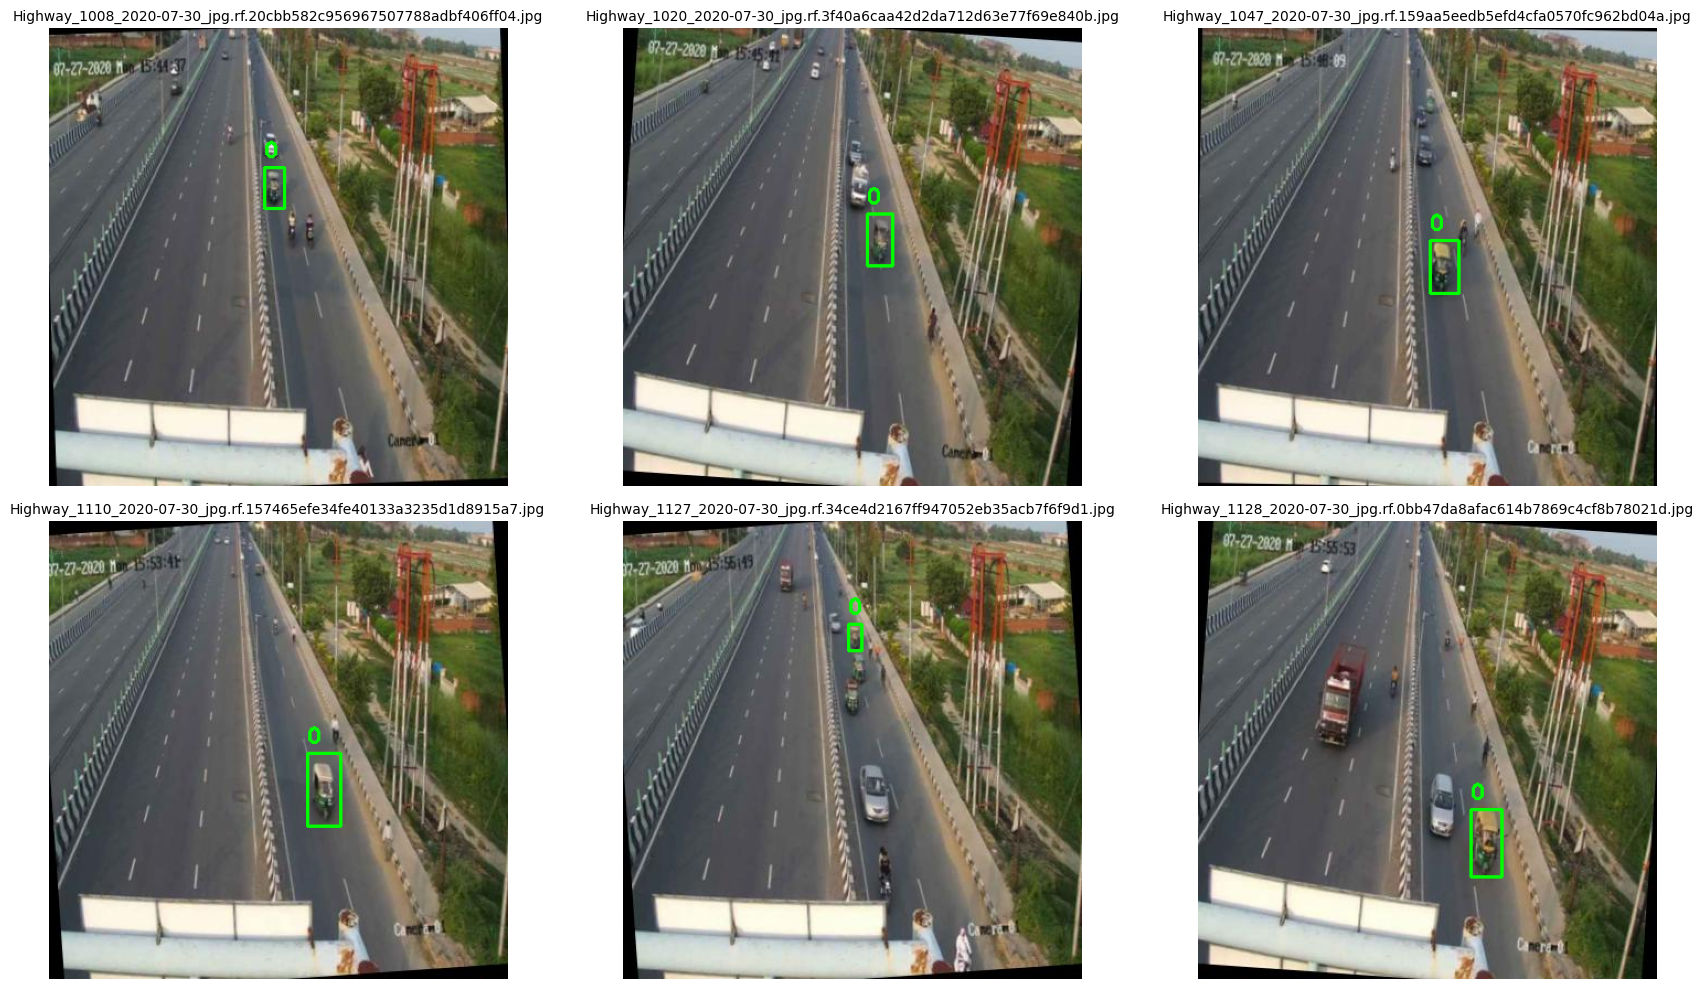

In [45]:
show_image_with_all_bboxes(df_unique, filter_label=0)

Door op elk label nummer te filteren zijn we uitgekomen welke voertuigen ze allemaal zijn.

In [28]:
class_mapping = {
    0: 'Auto',
    1: 'Bus',
    2: 'Car',
    3: 'LCV',
    4: 'Motorcycle',
    5: 'Multi-Axle',
    6: 'Tractor',
    7: 'Truck'
}

df_classes = pd.DataFrame(list(class_mapping.items()), columns=['class_id', 'class_name'])
display(df_classes)


,class_id,class_name
0,0,Auto
1,1,Bus
2,2,Car
3,3,LCV
4,4,Motorcycle
5,5,Multi-Axle
6,6,Tractor
7,7,Truck


In [29]:
# Tel het aantal voorbeelden per label
label_counts = df_kaggle['label'].value_counts().sort_index()
label_counts

,count
label,
0,817
1,1318
2,11403
3,969
4,7271
5,1145
6,171
7,2960


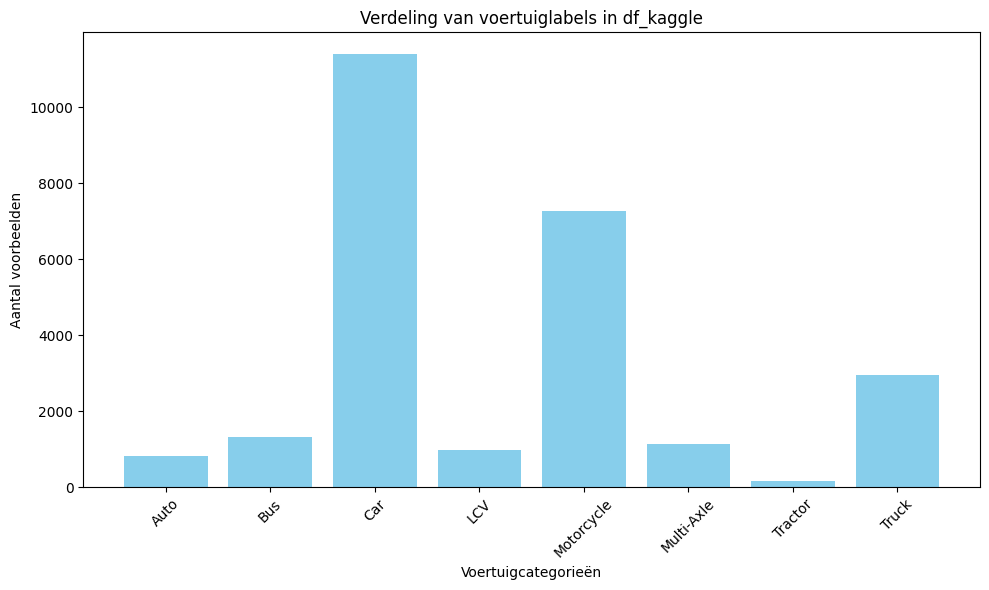

In [30]:
# Zet index om naar klassenamen
label_names = [class_mapping[i] for i in label_counts.index]

# Maak de staafgrafiek
plt.figure(figsize=(10, 6))
plt.bar(label_names, label_counts.values, color='skyblue')
plt.title('Verdeling van voertuiglabels in df_kaggle')
plt.xlabel('Voertuigcategorieën')
plt.ylabel('Aantal voorbeelden')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

De data in deze dataset is niet goed verdeeld over de verschillende voertuigcategorieën. Sommige klassen, zoals "Car" en "Motorcycle", komen zeer vaak voor, terwijl andere zoals "Tractor" en "Auto" nauwelijks voorkomen. Deze scheve verdeling, ook wel class imbalance genoemd, kan nadelig zijn voor het trainen van een betrouwbaar model, omdat het model vooral leert van de dominante categorieën en daardoor minder goed presteert op de minder voorkomende klassen.

# 3. Data Opschonen en Transformeren

Beschrijf de stappen voor data cleaning, data augmentation en data transformation.

In deze sectie beschrijf je de stappen voor het opschonen en transformeren van de data. Gebruik markdown-cellen om elke stap te beschrijven en code-cellen om de transformaties uit te voeren.

Data Cleaning

Beschrijf hoe je de afbeeldingen opschoont (bijvoorbeeld door ze allemaal naar hetzelfde formaat te converteren).

Voer kleurnormalisatie uit en pas cropping en padding toe waar nodig.

Data Augmentation

Beschrijf hoe je data augmentation toepast om de dataset te vergroten en het model robuuster te maken.

Gebruik technieken zoals rotatie, spiegeling, schalen, translatie, shearing en cropping.

Data Transformation

Beschrijf hoe je de afbeeldingen transformeert om ze geschikt te maken voor machine learning (bijvoorbeeld normalisatie en kleurtransformaties).

## 3.1 Data Cleaning

## 3.2 Data Augmentation

## 3.3 Data Transformation

# 4. Machine Learning Pipeline

Beschrijf hoe het objectdetectiemodel wordt getraind en geëvalueerd.


In deze sectie beschrijf je hoe je het objectdetectiemodel traint en evalueert. Gebruik markdown-cellen om elke stap te beschrijven en code-cellen om het model te trainen en te evalueren.

Objectdetectie Model

Beschrijf hoe je een objectdetectiemodel (bijvoorbeeld YOLO, Faster R-CNN of EfficientDet) traint op de dataset.

Leg uit hoe je het model evalueert met behulp van metrieken zoals precisie, recall en F1-score.

Image Captioning

Beschrijf eventueel hoe je een image captioning-model toevoegt om beschrijvingen van gedetecteerde voertuigen te genereren.



## 4.1 Train-Test Split

**uitleg

```
working/dataset/
├── big_model/
│   ├── images/
│   │   ├── train/           ← training images
│   │   └── val/             ← validation images
│   ├── labels/
│   │   ├── train/           ← labels for training images
│   │   └── val/             ← labels for validation images
│   └── vehicles_full.yaml   ← data.yaml for big model

├── small_model/
│   ├── images/
│   │   ├── train/           ← training images (same as big_model)
│   │   └── val/             ← validation images (same as big_model)
│   ├── labels/
│   │   ├── train/           ← generic "vehicle" labels
│   │   └── val/
│   └── vehicles_general.yaml ← data.yaml for small model
```

In [ ]:
data_dir = base_dir / 'working/dataset'

images = [f for f in os.listdir(images_path) if f.endswith('.jpg')]
labels = [f.replace('.jpg', '.txt') for f in images]

In [ ]:
# data_dir = base_dir / 'working/dataset'

# 💡 Remove the entire dataset folder if it exists
if os.path.exists(data_dir):
    shutil.rmtree(data_dir)

# Define all needed subdirectories
subdirs = [
    data_dir / 'big_model/images/train',
    data_dir / 'big_model/images/val',
    data_dir / 'big_model/labels/train',
    data_dir / 'big_model/labels/val',
    data_dir / 'small_model/images/train',
    data_dir / 'small_model/images/val',
    data_dir / 'small_model/labels/train',
    data_dir / 'small_model/labels/val'
]

# Create all directories
for subdir in subdirs:
    subdir.mkdir(parents=True, exist_ok=True)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# copy data
for img, lbl in zip(train_images, train_labels):
    shutil.copy(images_path / img, data_dir / 'big_model/images/train' / img)
    shutil.copy(labels_path / lbl, data_dir / 'big_model/labels/train' / lbl)
    shutil.copy(images_path / img, data_dir / 'small_model/images/train' / img)

for img, lbl in zip(test_images, test_labels):
    shutil.copy(images_path / img, data_dir / 'big_model/images/val' / img)
    shutil.copy(labels_path / lbl, data_dir / 'big_model/labels/val' / lbl)
    shutil.copy(images_path / img, data_dir / 'small_model/images/val' / img)


In [ ]:
def convert_to_generic_label(src_label_path, dst_label_path):
    """Converts any YOLO label file to class '0' only"""
    with open(src_label_path, 'r') as f_in, open(dst_label_path, 'w') as f_out:
        for line in f_in:
            parts = line.strip().split()
            if len(parts) == 5:  # YOLO label format
                # Replace the class ID with '0', keep the rest
                new_line = '0 ' + ' '.join(parts[1:]) + '\n'
                f_out.write(new_line)

small_train_dir = data_dir / 'small_model/labels/train'
small_val_dir = data_dir / 'small_model/labels/val'

# Create generic labels for small model
for lbl in train_labels:
    src_path = labels_path / lbl  # original big_model label
    dst_path = small_train_dir / lbl  # new small_model label
    convert_to_generic_label(src_path, dst_path)

for lbl in test_labels:
    src_path = labels_path / lbl
    dst_path = small_val_dir / lbl
    convert_to_generic_label(src_path, dst_path)

## 4.2 Model Bouwen

**uitleg

In [ ]:
data_yaml = {
    'train': 'images/train',
    'val': 'images/val',
    'nc': 1,
    'names': ['vehicle']
}

small_model_path = data_dir / 'small_model'

with open(small_model_path / 'vehicles_general.yaml', 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

## 4.3 Model Trainen

**uitleg

In [ ]:
project_path = base_dir / 'runs'
os.makedirs(project_path, exist_ok=True)

### Yolo Nano

Binnen YOLO zijn er varianten met de letter “n” in de modelnaam, zoals YOLOv10n, YOLO11n en YOLO12n. De “n” staat hierbij voor Nano en duidt aan dat het gaat om de kleinste en meest efficiënte versies van elk model.

YOLO Nano-modellen zijn speciaal ontworpen voor situaties waarin weinig rekenkracht beschikbaar is. Ondanks hun compacte formaat kunnen deze modellen verrassend goede prestaties leveren in toepassingen zoals detectie, classificatie en segmentatie. Deze optimalisatie is nodig voor real-time toepassingen op energiezuinige of draagbare apparaten, bijvoorbeeld op edge devices zoals de NVIDIA Jetson Nano [(Kim, 2024)](https://medium.com/@elvenkim1/yolov8-nano-vs-yolov8-large-4f21324baa38).

Volgens Ultralytics, is het best om zelf meerdere modellen te testen, want de scores kunnen variëren door het trainen op eigen datasets. Daarom kiezen we om de latest models (yolov10, yolo11 en yolo12) te testen [(Ultralytics, 2025a)](https://youtu.be/mcqTxD-FD5M?t=118).


- Ultralytics. (2025a, februari 21). How to Use YOLO12 for Object Detection with the Ultralytics Package | Is YOLO12 Fast or Slow? 🚀 [Video]. YouTube. https://www.youtube.com/watch?v=mcqTxD-FD5M
- Kim, E. (2024, 18 november). YOLOv8 Nano vs YOLOv8 large - Elven Kim - Medium. Medium. https://medium.com/@elvenkim1/yolov8-nano-vs-yolov8-large-4f21324baa38

In [ ]:
# Laad een YOLO model
model = YOLO('yolo12n.pt')

# Definieer het pad naar je data.yaml bestand
data_yaml_path = small_model_path / 'vehicles_general.yaml'

# Train het model
results = model.train(data=data_yaml_path, epochs=10, plots=True, save=True, name='yolo12n', project=project_path)

Ultralytics 8.3.154 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/vehicles_general.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo12n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tru

train: Scanning /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/labels/train.cache... 6574 images, 11 backgrounds, 0 corrupt: 100%|██████████| 6574/6574 [00:00<?, ?it/s]

train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2611_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2651_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2690_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2695_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2696_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2751_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2784_2020-08

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.4±0.9 ms, read: 13.4±8.2 MB/s, size: 66.1 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/labels/val.cache... 1644 images, 7 backgrounds, 0 corrupt: 100%|██████████| 1644/1644 [00:00<?, ?it/s]

val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2517_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2682_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2744_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2771_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2908_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_3001_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_3289_2020-08-26.jpg: 1 duplicate labels 

Plotting labels to /content/drive/MyDrive/Colab Notebooks/data/runs/yolo12n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)


2025/06/13 13:44:27 INFO mlflow.tracking.fluent: Experiment with name '/content/drive/MyDrive/Colab Notebooks/data/runs' does not exist. Creating a new experiment.
2025/06/13 13:44:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/06/13 13:44:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/06/13 13:44:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/06/13 13:44:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2025/06/13 13:44:28 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/06/13 13:44:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(7ee3237d113d43d78ea59efaff9ef88f) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Colab Notebooks/data/runs/yolo12n
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.24G      1.511       1.46      1.185         38        640: 100%|██████████| 411/411 [02:35<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:20<00:00,  2.48it/s]


                   all       1644       5243      0.781      0.792      0.854      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.66G      1.477      0.972      1.207         35        640: 100%|██████████| 411/411 [02:27<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.80it/s]


                   all       1644       5243      0.819      0.825      0.882      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.67G      1.447     0.8703      1.189         31        640: 100%|██████████| 411/411 [02:26<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.75it/s]


                   all       1644       5243      0.819      0.818      0.876      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.68G      1.412     0.8141      1.172         38        640: 100%|██████████| 411/411 [02:25<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  2.92it/s]


                   all       1644       5243      0.851      0.845      0.913      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.68G      1.375     0.7633      1.156         40        640: 100%|██████████| 411/411 [02:25<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  2.96it/s]


                   all       1644       5243      0.866      0.866      0.926      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.68G      1.346     0.7329      1.144         42        640: 100%|██████████| 411/411 [02:23<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.84it/s]


                   all       1644       5243      0.866      0.866      0.927      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.68G      1.311     0.6909      1.128         41        640: 100%|██████████| 411/411 [02:23<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  2.92it/s]

                   all       1644       5243      0.862      0.875      0.929      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.68G      1.283     0.6627      1.114         38        640: 100%|██████████| 411/411 [02:25<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.83it/s]


                   all       1644       5243      0.864      0.875      0.934       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.68G      1.251     0.6373      1.099         36        640: 100%|██████████| 411/411 [02:24<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.79it/s]

                   all       1644       5243      0.871      0.882      0.941      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.68G       1.23     0.6128       1.09         39        640: 100%|██████████| 411/411 [02:25<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  2.93it/s]


                   all       1644       5243      0.866      0.881      0.941      0.624

10 epochs completed in 0.460 hours.
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/data/runs/yolo12n/weights/last.pt, 5.5MB
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/data/runs/yolo12n/weights/best.pt, 5.5MB

Validating /content/drive/MyDrive/Colab Notebooks/data/runs/yolo12n/weights/best.pt...
Ultralytics 8.3.154 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,556,923 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:21<00:00,  2.42it/s]


                   all       1644       5243      0.866      0.881      0.941      0.624
Speed: 0.3ms preprocess, 3.9ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to /content/drive/MyDrive/Colab Notebooks/data/runs/yolo12n
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


In [ ]:
# Laad een YOLO model
model = YOLO('yolo11n.pt')

# Train het model
results = model.train(data=data_yaml_path, epochs=10, plots=True, save=True, imgsz=480, project=project_path, name='yolo11n')

Ultralytics 8.3.154 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/vehicles_general.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=480, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tru

train: Scanning /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/labels/train.cache... 6574 images, 11 backgrounds, 0 corrupt: 100%|██████████| 6574/6574 [00:00<?, ?it/s]

train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2611_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2651_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2690_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2695_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2696_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2751_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2784_2020-08

val: Fast image access ✅ (ping: 2.5±2.8 ms, read: 7.1±1.6 MB/s, size: 66.1 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/labels/val.cache... 1644 images, 7 backgrounds, 0 corrupt: 100%|██████████| 1644/1644 [00:00<?, ?it/s]

val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2517_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2682_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2744_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2771_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2908_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_3001_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_3289_2020-08-26.jpg: 1 duplicate labels 

Plotting labels to /content/drive/MyDrive/Colab Notebooks/data/runs/yolo11n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)


2025/06/13 14:14:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/06/13 14:14:08 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/06/13 14:14:08 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/06/13 14:14:08 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2025/06/13 14:14:08 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/06/13 14:14:08 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(b10d009009f345e9bc5a6ab1d1030e98) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 480 train, 480 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Colab Notebooks/data/runs/yolo11n
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.36G      1.495      1.377      1.106         38        480: 100%|██████████| 411/411 [01:47<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:15<00:00,  3.46it/s]


                   all       1644       5243      0.796      0.829      0.877      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.62G      1.453     0.9209      1.106         35        480: 100%|██████████| 411/411 [01:44<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.53it/s]


                   all       1644       5243      0.815      0.819      0.875      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.62G      1.435     0.8392      1.109         31        480: 100%|██████████| 411/411 [01:41<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.58it/s]


                   all       1644       5243      0.834      0.861      0.897      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.62G      1.395     0.7796      1.089         38        480: 100%|██████████| 411/411 [01:40<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.61it/s]


                   all       1644       5243      0.832      0.848      0.904      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.62G       1.36     0.7436      1.075         40        480: 100%|██████████| 411/411 [01:41<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.52it/s]


                   all       1644       5243      0.836      0.862      0.917      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.62G      1.327     0.7105      1.062         42        480: 100%|██████████| 411/411 [01:41<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.49it/s]

                   all       1644       5243      0.872      0.854      0.924      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.62G      1.297     0.6759      1.052         41        480: 100%|██████████| 411/411 [01:40<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.57it/s]

                   all       1644       5243       0.86      0.866      0.927      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.62G      1.266     0.6509      1.039         38        480: 100%|██████████| 411/411 [01:40<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.51it/s]

                   all       1644       5243      0.882      0.871      0.937       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.62G      1.241     0.6277      1.032         36        480: 100%|██████████| 411/411 [01:39<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.74it/s]


                   all       1644       5243      0.873      0.886       0.94      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.62G      1.213     0.6033      1.018         39        480: 100%|██████████| 411/411 [01:52<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  3.03it/s]

                   all       1644       5243      0.872      0.879      0.943      0.622



10 epochs completed in 0.331 hours.
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/data/runs/yolo11n/weights/last.pt, 5.4MB
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/data/runs/yolo11n/weights/best.pt, 5.4MB

Validating /content/drive/MyDrive/Colab Notebooks/data/runs/yolo11n/weights/best.pt...
Ultralytics 8.3.154 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:16<00:00,  3.20it/s]


                   all       1644       5243      0.872       0.88      0.944      0.622
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /content/drive/MyDrive/Colab Notebooks/data/runs/yolo11n
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


In [ ]:
# Laad een YOLO model
model = YOLO('yolov10n.pt')

# Train het model
results = model.train(data=data_yaml_path, epochs=10, plots=True, save=True, project=project_path, name='yolo10n')

100%|██████████| 5.59M/5.59M [00:00<00:00, 91.6MB/s]


Ultralytics 8.3.154 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/vehicles_general.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True

100%|██████████| 755k/755k [00:00<00:00, 21.6MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

YOLOv10n summary: 223 layers, 2,707,430 parameters, 2,707,414 gradients, 8.4 GFLOPs

Transferred 493/595 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 96.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.6±0.2 ms, read: 0.1±0.0 MB/s, size: 29.0 KB)


train: Scanning /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/labels/train.cache... 6574 images, 14 backgrounds, 0 corrupt: 100%|██████████| 6574/6574 [00:00<?, ?it/s]

train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2651_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2682_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2690_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2696_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2744_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2751_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2771_2020-08

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 0.2±0.2 MB/s, size: 66.6 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/labels/val.cache... 1644 images, 4 backgrounds, 0 corrupt: 100%|██████████| 1644/1644 [00:00<?, ?it/s]

val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2517_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2611_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2695_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_3432_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_3599_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_3745_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/ulu1035_jpg.rf.e281567375e34e6eb8c273fbd14f7836.

Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)


2025/06/12 19:34:43 INFO mlflow.tracking.fluent: Experiment with name '/Shared/Ultralytics' does not exist. Creating a new experiment.
2025/06/12 19:34:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/06/12 19:34:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/06/12 19:34:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/06/12 19:34:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2025/06/12 19:34:49 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/06/12 19:34:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(f9e5a2a7e4e14abaa6636c4adb9d2764) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.74G      3.019       4.65      2.322         30        640: 100%|██████████| 411/411 [36:09<00:00,  5.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.77it/s]


                   all       1644       5290      0.705      0.709      0.751      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.23G      3.037      2.258      2.365         34        640: 100%|██████████| 411/411 [02:21<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  3.06it/s]

                   all       1644       5290      0.724      0.738      0.793      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.23G      2.981      1.826      2.357         32        640: 100%|██████████| 411/411 [02:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  2.92it/s]

                   all       1644       5290      0.787      0.758      0.842       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.25G      2.897      1.653      2.319         50        640: 100%|██████████| 411/411 [02:18<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  2.96it/s]


                   all       1644       5290      0.801      0.814      0.871      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.26G      2.847      1.539      2.284         45        640: 100%|██████████| 411/411 [02:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  3.05it/s]

                   all       1644       5290      0.821      0.818      0.884      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.26G      2.757       1.45      2.244         31        640: 100%|██████████| 411/411 [02:20<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:16<00:00,  3.07it/s]

                   all       1644       5290      0.819      0.832      0.889      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.28G      2.696      1.376      2.214         40        640: 100%|██████████| 411/411 [02:21<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  2.98it/s]

                   all       1644       5290      0.827       0.84      0.901      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.28G      2.632      1.321      2.193         43        640: 100%|██████████| 411/411 [02:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:16<00:00,  3.08it/s]


                   all       1644       5290      0.855      0.845      0.913      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.28G      2.581       1.27      2.169         47        640: 100%|██████████| 411/411 [02:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  3.01it/s]


                   all       1644       5290      0.857      0.848      0.919      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.28G      2.514      1.207      2.144         39        640: 100%|██████████| 411/411 [02:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.81it/s]

                   all       1644       5290      0.872      0.858      0.926       0.61



10 epochs completed in 1.007 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.154 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,265,363 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.76it/s]


                   all       1644       5290      0.873      0.858      0.926       0.61
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


## 4.4 Model Evalueren

In [ ]:
eval_path = base_dir / 'evaluation'
model_name = 'yolo12n'
model = YOLO(project_path / f'detect/{model_name}/weights/best.pt')

results = model('', save=True, name=model_name, project=eval_path, imgsz=640)

# 5. Deployment

Beschrijf hoe het model wordt gedeployed op edge-apparaten en in de cloud.

In deze sectie beschrijf je hoe je het model deployt op edge-apparaten en in de cloud. Gebruik markdown-cellen om de deploymentstrategie te beschrijven.

Edge Deployment

Beschrijf hoe je het model implementeert op edge-apparaten zoals slimme camera's of embedded systemen.

Leg uit hoe je ervoor zorgt dat het model realtime voertuigdetectie kan uitvoeren.

Cloud Deployment

Beschrijf hoe je het geavanceerde deep learning-model in de cloud deployt voor voertuigclassificatie.



## 5.1 Edge Deployment

## 5.2 Cloud Deployment

# 6. Monitoring en Feedback

Beschrijf hoe de prestaties van het model worden gemonitord en hoe het model wordt hertraind op basis van nieuwe data.

In deze sectie beschrijf je hoe je de prestaties van het model monitort en hoe je het model hertraind op basis van nieuwe data. Gebruik markdown-cellen om de monitoringstrategie te beschrijven.

Data Drift Detection

Beschrijf hoe je veranderingen in de inkomende data detecteert en hoe je hierop reageert.

Model Performance Monitoring

Beschrijf hoe je de nauwkeurigheid, recall en precision van het model continu monitort.

Leg uit hoe je automatisch logging van verkeerde voorspellingen implementeert.

Hertraining

Beschrijf hoe je het model periodiek hertraind op basis van nieuwe data en feedback.

7. Conclusie


## 6.1 Data Drift Detection

## 6.2 Hertraining

# 7. Conclusie

Geef een samenvatting van de datapijplijn en bespreek eventuele uitdagingen of verbeterpunten.

In deze sectie geef je een samenvatting van de datapijplijn en bespreek je eventuele uitdagingen of verbeterpunten. Gebruik markdown-cellen om de conclusie te schrijven.




# 8. Bronvermelding